# Analaysis of Seattle Airbnb Open Data

### Table of Contents
* [1. Background](#section_1)

* [2.Business Understanding](#section_2)

* [3.Data Understanding](#section_3)
    * [3.1 Calendar](#section_3_1)
    * [3.2 Listings](#section_3_2)
    * [3.3 Reviews](#section_3_3)
    
* [4. Data Preparation](#section_4)
    * [4.1. Calendar](#section_4_1)
    * [4.2. Listings](#section_4_2)
        * [4.2.1. Narrowing down features](#section_4_2_1)
        * [4.2.2. Data cleaning](#section_4_2_2)
        
* [5. Data Modeling](#section_5)
    * [5.1. Splitting the data](#section_5_1)
    * [5.2. Modeling](#section_5_2)

### 1. Background <a class="anchor" id="section_1"></a>
In this notebook we look at Airbnb data around the Seattle area. A few questions will be asked and then data science methodology used to answer them. Throughout this work the CRISP-DM (Cross Industry Standard Process for Data Mining) process will be followed.

The data used is opensource and available on [Kaggle](https://www.kaggle.com/datasets/airbnb/seattle/version/1/metadata).

### 2. Business Understanding <a class="anchor" id="section_2"></a>
#### Questions

1. What are the most expensive periods to vist?
2. Where are the expensive listings in Seattle?
3. How accurately can we predict a listing's price?
4. What contributes to the price of a listing and how does it impact the price?

### 3. Data Understanding <a class="anchor" id="section_3"></a>

Starting off by importing libraries required for the exploration and analysis and then looking at the size of the different datasets.

In [1300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline

In [1069]:
# Loading all the data 
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')
calendar = pd.read_csv('calendar.csv')

listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [1070]:
# How big is each dataset?
print(listings.shape, reviews.shape, calendar.shape)

(3818, 92) (84849, 6) (1393570, 4)


Above are the sizes of the given data (listings, calendar and reviews). Next we will look closer at the individual datasets and look at datatypes and missing values.

### 3.1. Calendar <a class="anchor" id="section_3_1"></a>

In [1071]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [1072]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


Other than the *listing_id* all other columns contain stings. We can see that these are not ideal datatype for the values given. To make better use of the data, here are the data types we should use instead:

* **date** -> datetime
* **available** -> boolean
* **price** -> float

However, before making any conversions let's look at the other datasets and understand which features would in fact be useful to keep for further analysis.

In [1073]:
calendar['available'].unique()

array(['t', 'f'], dtype=object)

### 3.2. Listings <a class="anchor" id="section_3_2"></a>

In [1074]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

*listings* contains far more columns than the other two datasets. This will make it a lot more difficult to go through and clean, especially considering the amount of features with null values. 

Given the questions we want to answer some features will be irrelevant and this will be taken into account when cleaning the data. Furhtermore, suitable imputation methods will need to be used to deal with null values in a reasonal manner. This will need to be dealt with in a case by case manner.

### 3.3. Reviews <a class="anchor" id="section_3_3"></a>

In [1075]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [1076]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


Are there reviewers that rent frequently?

In [1077]:
reviews['reviewer_id'].value_counts().head(20)

206203      67
15121499    32
5775807     19
2734499     19
29590276    18
7448809     17
8013961     16
1971733     14
41158892    14
5053141     14
12934633    13
7485789     13
1499027     13
2316057     12
13896249    12
4274504     12
10331180    12
20640343    12
3029106     11
10132034    11
Name: reviewer_id, dtype: int64

In [1078]:
listings[listings['id'] == 7202016]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3226,7202016,https://www.airbnb.com/rooms/7202016,20160104002432,2016-01-04,Cute Mid Century near Downtown,Cute mid century condo within walking distance...,"Mid century condo, super airy and spacious. H...",Cute mid century condo within walking distance...,none,"Neighborhood has everything. Coffee, restaura...",...,10.0,f,NaN,WASHINGTON,t,flexible,f,f,1,2.82


In [1079]:
# Finding out which columns have no null values (if they even exist)

no_nulls = listings.columns[listings.isnull().sum() > 0]
len(no_nulls)

45

Are all properties listed unique? Looks like they are.

In [1080]:
listings['id'].nunique()

3818

### 4. Data Preparation <a class="anchor" id="section_4"></a>

### 4.1. Calendar <a class="anchor" id="section_4_1"></a>

In [1081]:
# creating a fucntion to deal with numeric values that are strings 

def pick_numeric(df, cols, dtype_output):
    '''
    This function will extract all numeric values from strings and convert them
    into a desired datatype. 
    The function is primarily intended to be used with prices.
    
    df = pandas DataFrame to be used
    cols = columns to be converted. Columns to be provided as list
    dtype_output = desired datatype out put wanted (e.g. int, float, etc.)
    '''
    
    for col in cols:
        df[col] = df[col].str.extract('(\d+)')
        df[col] = df[col].astype(dtype_output)

In [1082]:
pick_numeric(df=calendar, cols=['price'], dtype_output=float)

(array([449601., 341284.,  89671.,  29836.,  11292.,   5488.,   3022.,
          2803.,    635.,    910.]),
 array([  1. , 100.8, 200.6, 300.4, 400.2, 500. , 599.8, 699.6, 799.4,
        899.2, 999. ]),
 <BarContainer object of 10 artists>)

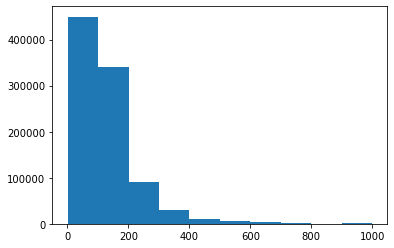

In [1083]:
plt.hist(calendar.price)

Looking at the price distribution we can see that the majority of properties are below \\$300. There are also some particularly expensive properties with list prices of > \\$900. To understand what these more expensive properties differentiates them from the cheaper ones we will have to look at the **listings** dataframe in the next section.

In [1084]:
# Converting all columns into appropriate data types for further analysis
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['available'] = calendar['available'].map({'t':1, 'f':0})
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  int64         
 3   price       934542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 42.5 MB


The above is better than before for exploration and gaining insight. 

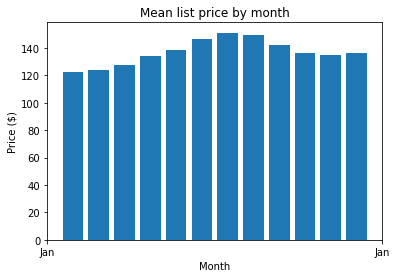

In [1302]:
# plotting the mean listing price across the year 
annual = calendar.groupby(calendar['date'].dt.month)['price'].mean()
plt.bar(annual.index, annual)
plt.xlabel('Month')
plt.ylabel('Price ($)')
plt.title('Mean list price by month');

locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')


#plt.plot(date_list,y)
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()

From the barplot above we can see that summer is the most expensive season. Specifically July has on average the most expensive list price. After July prices come down gradually, but increase again slightly in December.

### 4.2. Listings <a class="anchor" id="section_4_2"></a>
The cleaned calendar data allowed us to gain some quick but interesting insight into Airbnb list price changes throughout the year. Unfortunately, this information alone is not enough to answer the questions we asked at the beginning. There are a lot of details provided in the *listings* dataset, which we can use to predict and gain better understanding of property pricing.

Firt we must clean and prepare the data though, which will be the focus in this section. Furthermore, not all features will be useful to us, so we will remvoe these all together. Examples of these are as follows:

* Long and unique text descriptions (e.g. *space, summary, description, neighborhood_overview, notes*, etc)
* Url's (e.g. *thumbnail_url, medium_url*, etc.)
* Empty columns or columns with significant amount of data missing (e.g. *experiences_offered*)
* Not all but some host details (e.g. *host_name, host_about*, etc)
* Missing too many values (e.g. *license, square_feet*)
* Price - a couple of different ones are given (e.g. listing, weekly and monthly). For this analysis we will stick to just listing price

Once these have been removed we can look into separating and amending the datatypes according to wether they are numerical or categorical.

And finally all null values will be treated using suitable imputation methods.

**Note:**
All features given were reviewed for the tye of values provided and their usefulness for coming analysis steps. To avoid cluttering the workspace, cells used for those steps are not shown.

### 4.2.1. Narrowing down features <a class="anchor" id="section_4_2_1"></a>

In [1086]:
(listings.isna().sum()/listings.shape[0]).sort_values(ascending=False).head(15)

license                   1.000000
square_feet               0.974594
monthly_price             0.602672
security_deposit          0.511262
weekly_price              0.473808
notes                     0.420639
neighborhood_overview     0.270299
cleaning_fee              0.269775
transit                   0.244631
host_about                0.224987
host_acceptance_rate      0.202462
review_scores_accuracy    0.172342
review_scores_checkin     0.172342
review_scores_value       0.171818
review_scores_location    0.171556
dtype: float64

In [1087]:
listings.transit.nunique()

2574

In [1088]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [1089]:
listings.name.nunique()

3792

In [1090]:
to_drop = ['name','listing_url','scrape_id','last_scraped','summary',
          'space', 'description','experiences_offered','neighborhood_overview',
          'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name','host_about',
          'host_thumbnail_url', 'host_picture_url','neighbourhood', 'city',
          'market','smart_location','country_code','country','calendar_last_scraped',
          'requires_license', 'license', 'jurisdiction_names','square_feet', 'street',
          'host_since', 'host_has_profile_pic','neighbourhood_group_cleansed', 'state',
          'is_location_exact','weekly_price', 'monthly_price','first_review','last_review',
          'host_acceptance_rate', 'host_verifications', 'calendar_updated', 'has_availability',
          'host_location', 'host_neighbourhood']

In [1091]:
listings_sml = listings.copy()

In [1092]:
listings_sml = listings_sml.drop(to_drop, axis=1)
listings_sml.head()

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,zipcode,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,within a few hours,96%,f,3.0,3.0,t,West Queen Anne,98119,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,5177328,within an hour,98%,t,6.0,6.0,t,West Queen Anne,98119,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,16708587,within a few hours,67%,f,2.0,2.0,t,West Queen Anne,98119,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,9851441,NaN,NaN,f,1.0,1.0,t,West Queen Anne,98119,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,278830,1452570,within an hour,100%,f,2.0,2.0,t,West Queen Anne,98119,...,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


In [1093]:
listings_sml.zipcode

0       98119
1       98119
2       98119
3       98119
4       98119
        ...  
3813    98107
3814    98102
3815    98178
3816    98112
3817    98109
Name: zipcode, Length: 3818, dtype: object

In [1094]:
usefulness = listings_sml.isnull().sum(axis=1)/listings_sml.shape[1]
usefulness[usefulness>0.25].count()

111

In [1095]:
listings_sml[usefulness>0.25]

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,zipcode,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3,7421966,9851441,NaN,NaN,f,1.0,1.0,t,West Queen Anne,98119,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
18,7735464,6170760,NaN,NaN,f,1.0,1.0,t,West Queen Anne,98119,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
23,10106055,51860756,NaN,NaN,f,1.0,1.0,f,West Queen Anne,98119,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
53,10310373,53050379,NaN,NaN,f,1.0,1.0,f,West Queen Anne,98119,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
70,7021702,36805437,NaN,NaN,f,1.0,1.0,f,Adams,98107,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,6169489,32008173,NaN,NaN,f,1.0,1.0,t,Fremont,98103,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
3685,10060674,14088426,NaN,NaN,f,1.0,1.0,f,Fremont,98103,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
3743,3931346,5062312,NaN,NaN,f,1.0,1.0,f,Fremont,98107,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
3800,5482204,28432113,NaN,NaN,f,1.0,1.0,f,Fremont,98103,...,NaN,NaN,NaN,NaN,f,strict,f,f,1,NaN


### 4.2.2. Data cleaning (Numerical) <a class="anchor" id="section_4_2_2"></a>
Now that we have selected features to keep for further analysis we still need to clean the data. Steps will include the following:

* Separating numerical from categorical data
* Fix null values
* Fixing data types (e.g. convert strings to int or floats)
* Encode categorical data

In [1096]:
# fixing a remaining date column
#listings_sml['host_since'] = pd.to_datetime(listings_sml['host_since'])

In [1097]:
# Pick out only numeric values and convert to float
#listings_sml['host_response_rate'] = listings_sml['host_response_rate'].str.extract('(\d+)')
#listings_sml['host_response_rate'] = listings_sml['host_response_rate'].astype(float)/100

pick_numeric(listings_sml, cols=['host_response_rate'], dtype_output=float)

In [1098]:
listings_sml.zipcode.value_counts()

98122        420
98103        394
98102        339
98105        225
98109        202
98101        201
98144        200
98121        196
98107        180
98115        178
98112        167
98117        164
98118        154
98119        143
98116        112
98104         95
98125         71
98199         66
98126         63
98106         58
98108         56
98133         46
98136         44
98177         19
98178          7
98134          5
98146          5
99\n98122      1
Name: zipcode, dtype: int64

In [1099]:
# The zipcodes columns contains one corrupted input. 
#The last part of the of the zipcode seems to be correct however. 
listings_sml.loc[listings_sml['zipcode'] == '99\n98122','zipcode'] = '98122'
listings_sml['zipcode'] = listings_sml['zipcode'].astype(float)

# convert the price column to float as in the previous calendar dataframe
pick_numeric(listings_sml, cols=['price', 'security_deposit','cleaning_fee', 'extra_people'], dtype_output=float)

In [1100]:
# filling the missing numeric values
# In this case using the mean seems most reasonable, though other imputation methods could be used

num_vars = listings_sml.select_dtypes(include=['float','int']).columns
for col in num_vars:
    listings_sml[col].fillna((listings_sml[col].mean()), inplace=True)

In [1101]:
listings_sml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   host_id                           3818 non-null   int64  
 2   host_response_time                3295 non-null   object 
 3   host_response_rate                3818 non-null   float64
 4   host_is_superhost                 3816 non-null   object 
 5   host_listings_count               3818 non-null   float64
 6   host_total_listings_count         3818 non-null   float64
 7   host_identity_verified            3816 non-null   object 
 8   neighbourhood_cleansed            3818 non-null   object 
 9   zipcode                           3818 non-null   float64
 10  latitude                          3818 non-null   float64
 11  longitude                         3818 non-null   float64
 12  proper

In [1102]:
listings_sml.amenities.unique()

array(['{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}',
       '{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}',
       '{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo}',
       ...,
       '{"Cable TV","Wireless Internet",Kitchen,"Free Parking on Premises",Breakfast,"Pets live on this property",Dog(s),Cat(s),Heating,Washer,Dryer,"Smoke Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials,Hangers,"Hair Dryer",Iron,"Laptop Friendly Workspace"}',
       '{TV,"Wireless I

### 4.2.3. Data cleaning (Categorical) <a class="anchor" id="section_4_2_3">

Only four features have some missing data. The number of missing values is quite low, so there fore we could either drop those row entirely or fill the missing values. In this case the chosen method is to fill using the mode of the respective column. 

In [1103]:
# filling the missing values using the mode of each column
missing = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
          'property_type']
for col in missing:
    listings_sml[col].fillna((listings_sml[col].mode()[0]), inplace=True)

At the end of cleaning we will encode all categorical columns, which will increase the number of columns in the dataframe. The number of additional columns will depend on the number of categories.

In [1104]:
# How many categories are there currently in each column?
obj_cols = listings_sml.select_dtypes(include=['object']).columns
new_cols = []

for col in obj_cols:
    new_cols.append(listings_sml[col].nunique())

new_cols

[4, 2, 2, 87, 16, 3, 5, 3284, 2, 3, 2, 2]

One column in particular has a worrying number of categories, 3284. This is the amenities column and this will need to be cleaned up further before continuing. As one can see from the below cell each row contains a collection of various amenities in the form of a string. This is not very helpful and each cell needs to be parsed through, separated and added to a list. Doing this will allow us to use the MultiLabelBinarizer from sklearn for encoding.

In [1105]:
listings_sml['amenities'].value_counts()

{}                                                                                                                                                                                                                                                                                                                             45
{Internet,"Wireless Internet",Kitchen,"Free Parking on Premises",Heating,Washer,Dryer}                                                                                                                                                                                                                                         11
{TV,"Cable TV",Internet,"Wireless Internet",Pool,Kitchen,"Free Parking on Premises",Gym,"Elevator in Building","Hot Tub",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentials,Shampoo,"24-Hour Check-in",Hangers,"Hair Dryer",Iron}                           10
{TV,"Cable TV",Internet,"Wireless 

In [1106]:
type(listings_sml['amenities'][3])

str

In [1107]:
# Using a lambda function to format the each cell and create a list of 
# amenities that can be used for encoding later 
listings_sml['amenities'] = listings_sml['amenities'].map(lambda x: x.strip('{}').replace('"','').split(','))
listings_sml['amenities']

0       [TV, Cable TV, Internet, Wireless Internet, Ai...
1       [TV, Internet, Wireless Internet, Kitchen, Fre...
2       [TV, Cable TV, Internet, Wireless Internet, Ai...
3       [Internet, Wireless Internet, Kitchen, Indoor ...
4       [TV, Cable TV, Internet, Wireless Internet, Ki...
                              ...                        
3813    [TV, Cable TV, Internet, Wireless Internet, Ai...
3814    [TV, Cable TV, Internet, Wireless Internet, Ki...
3815    [Cable TV, Wireless Internet, Kitchen, Free Pa...
3816    [TV, Wireless Internet, Kitchen, Free Parking ...
3817    [TV, Cable TV, Internet, Wireless Internet, Ki...
Name: amenities, Length: 3818, dtype: object

Final check and it looks like there are no more null values. The final step for this dataset is encoding. Two different methods will have to be used here:

* MultiLabelBinarizer for 'amenities'
* pd.get_dummies for all the others

### 4.2.5. Data cleaning (Encoding) <a class="anchor" id="section_4_2_2">

In [1108]:
# list of columns to use the get_dummies method on
to_encode = list(listings_sml.select_dtypes(include='object').columns)
to_encode.remove('amenities')

In [1109]:
to_encode

['host_response_time',
 'host_is_superhost',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

In [1110]:
dummies_df = pd.get_dummies(listings_sml[to_encode], prefix_sep='_', drop_first=True)

In [1111]:
list(dummies_df.columns)

['host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_is_superhost_t',
 'host_identity_verified_t',
 'neighbourhood_cleansed_Alki',
 'neighbourhood_cleansed_Arbor Heights',
 'neighbourhood_cleansed_Atlantic',
 'neighbourhood_cleansed_Belltown',
 'neighbourhood_cleansed_Bitter Lake',
 'neighbourhood_cleansed_Briarcliff',
 'neighbourhood_cleansed_Brighton',
 'neighbourhood_cleansed_Broadview',
 'neighbourhood_cleansed_Broadway',
 'neighbourhood_cleansed_Bryant',
 'neighbourhood_cleansed_Cedar Park',
 'neighbourhood_cleansed_Central Business District',
 'neighbourhood_cleansed_Columbia City',
 'neighbourhood_cleansed_Crown Hill',
 'neighbourhood_cleansed_Dunlap',
 'neighbourhood_cleansed_East Queen Anne',
 'neighbourhood_cleansed_Eastlake',
 'neighbourhood_cleansed_Fairmount Park',
 'neighbourhood_cleansed_Fauntleroy',
 'neighbourhood_cleansed_First Hill',
 'neighbourhood_cleansed_Fremont',
 'neighbourhood_cleansed_Gatew

In [1112]:
pd.get_dummies(listings_sml['require_guest_phone_verification'])

,f,t
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
3813,1,0
3814,1,0
3815,1,0
3816,1,0


In [1113]:
listings_sml.shape

(3818, 45)

In [1114]:
# Add dummies to dataframe and drop obsolete columns at the same time
listings_clean = pd.concat([listings_sml.drop(to_encode, axis=1), dummies_df], axis=1)
listings_clean.head()

,id,host_id,host_response_rate,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,...,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_t,require_guest_phone_verification_t
0,241032,956883,96.000000,3.0,3.0,98119.0,47.636289,-122.371025,4,1.0,...,0,0,0,0,1,0,1,0,0,0
1,953595,5177328,98.000000,6.0,6.0,98119.0,47.639123,-122.365666,4,1.0,...,0,0,0,0,1,0,0,1,1,1
2,3308979,16708587,67.000000,2.0,2.0,98119.0,47.629724,-122.369483,11,4.5,...,0,0,0,0,1,0,0,1,0,0
3,7421966,9851441,94.886798,1.0,1.0,98119.0,47.638473,-122.369279,3,1.0,...,0,0,0,0,1,0,0,0,0,0
4,278830,1452570,100.000000,2.0,2.0,98119.0,47.632918,-122.372471,6,2.0,...,0,0,0,0,1,0,0,1,0,0


In [1115]:
mlb = MultiLabelBinarizer(sparse_output=True)

listings_clean = listings_clean.join(pd.DataFrame.sparse.from_spmatrix(
    mlb.fit_transform(listings_clean.pop('amenities')), index=listings_clean.index,
columns=mlb.classes_))

In [1116]:
listings_clean

,id,host_id,host_response_rate,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,241032,956883,96.000000,3.0,3.0,98119.0,47.636289,-122.371025,4,1.0,...,0,0,0,0,0,1,1,0,0,1
1,953595,5177328,98.000000,6.0,6.0,98119.0,47.639123,-122.365666,4,1.0,...,1,0,1,0,0,1,1,0,0,1
2,3308979,16708587,67.000000,2.0,2.0,98119.0,47.629724,-122.369483,11,4.5,...,0,1,1,0,0,1,1,0,0,1
3,7421966,9851441,94.886798,1.0,1.0,98119.0,47.638473,-122.369279,3,1.0,...,1,1,1,0,0,0,1,0,0,1
4,278830,1452570,100.000000,2.0,2.0,98119.0,47.632918,-122.372471,6,2.0,...,0,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,31148752,99.000000,354.0,354.0,98107.0,47.664295,-122.359170,6,2.0,...,0,1,1,0,0,1,1,0,1,1
3814,8902327,46566046,100.000000,1.0,1.0,98102.0,47.649552,-122.318309,4,1.0,...,0,1,1,0,0,1,0,0,0,1
3815,10267360,52791370,94.886798,1.0,1.0,98178.0,47.508453,-122.240607,2,1.0,...,1,0,1,0,0,0,1,0,0,1
3816,9604740,25522052,100.000000,1.0,1.0,98112.0,47.632335,-122.275530,2,1.0,...,0,0,1,0,0,1,0,0,0,1


In [1117]:
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 192 entries, id to Wireless Internet
dtypes: Sparse[int32, 0](42), float64(21), int64(12), uint8(117)
memory usage: 1.8 MB


### 5. Data Modeling <a class="anchor" id="section_5">

### 5.1. Splitting the Data  <a class="anchor" id="section_5_1">
The data needs to be separated into an explanatory matrix, **X**, and a response vector, **y**. In this case the response we want is the listing price, as described in the questions in section 1. Furthermore in this step the data will also be split into **test** and **train** data.

In [1118]:
# Creating the explanatory matrix and response vector
X = listings_clean.drop('price', axis=1)
y = listings_clean['price']

In [1119]:
# Here the X and y will get split into testing and training data

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)

### 5.2. Modeling <a class="anchor" id="section_5_2">

### 5.2.1. Linear Regression Model
First a linear regression will be used to predict listing prices of Airbnb properties using the cleaned *listings_clean* dataframe. 

In [1120]:
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

train_score, test_score

C:\Users\tjrones\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\tjrones\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\tjrones\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


(0.6539761974442325, 0.6112597478529762)

### 5.2.2. Random Forest Model
The linear model, as seen previously, only achieves an r2_score of 0.61 on test data. While this prediction is not the worst a higher score may be achieved using a different model. 

Below a random forest regressor is used to predict property prices. 

In [1121]:
# Creating the random forest model
rf_model = RandomForestRegressor(n_estimators=50,random_state=42)
rf_model.fit(X, y)

C:\Users\tjrones\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


RandomForestRegressor(n_estimators=50, random_state=42)

In [1122]:
# Making predictions using the new random forest regressor on both the train and test data
y_test_preds2 = rf_model.predict(X_test)
y_train_preds2 = rf_model.predict(X_train)

test_score2 = r2_score(y_test, y_test_preds2)
train_score2 = r2_score(y_train, y_train_preds2)

train_score2, test_score2

C:\Users\tjrones\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\tjrones\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


(0.9504123131068147, 0.9483027916308481)

The above result is much better and gives us much higher confidence in predicting house prices.

Next, the feature importances are looked at to understand which features contribute the most to a property's price.

In [1130]:
feature_names = list(X.columns)
feature_importances = list(rf_model.feature_importances_)

cols = {'feature_names':feature_names, 'feature_importances':feature_importances}

importances = pd.DataFrame(cols)
importances.set_index('feature_names', inplace=True)
importances.sort_values(by='feature_importances', ascending=False, inplace=True)
#importances = importances.sort_values(by='feature_importances', ascending=True)

In [1131]:
importances

,feature_importances
feature_names,
bedrooms,3.839248e-01
bathrooms,6.489431e-02
cleaning_fee,5.064603e-02
accommodates,4.227875e-02
security_deposit,3.101939e-02
...,...
neighbourhood_cleansed_Roxhill,6.607973e-07
neighbourhood_cleansed_Pinehurst,2.118258e-09
property_type_Dorm,1.345022e-09


<BarContainer object of 20 artists>

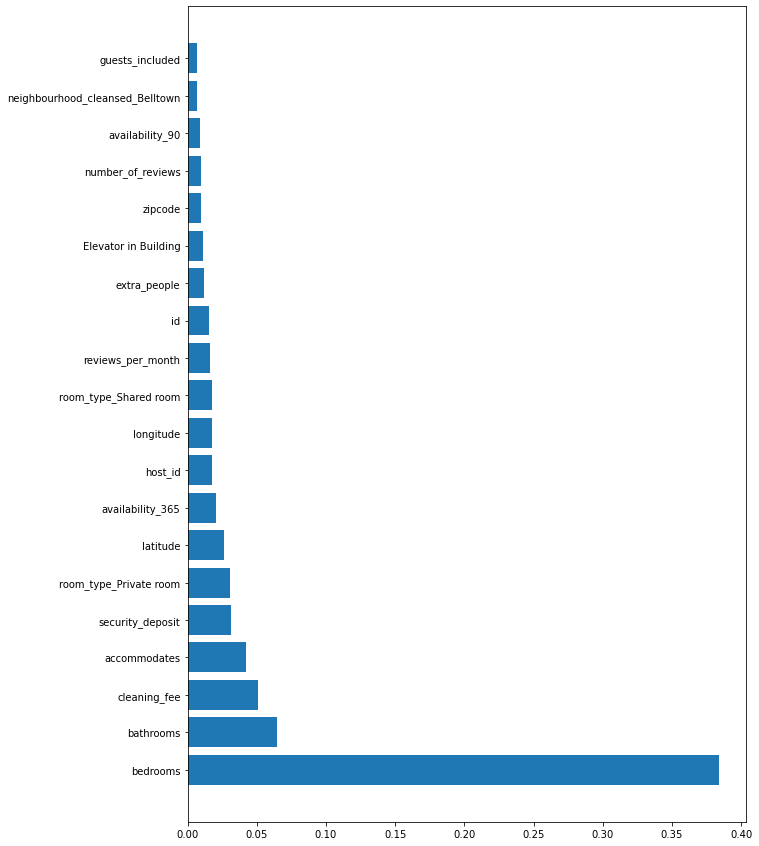

In [1133]:
plt.figure(figsize=(10, 15))
plt.barh(importances.index[:20], importances['feature_importances'][:20])

Overall the importance some of the features play in the impact on listing price makes sense. The largest contributor to price, according to the model used, is by far the number of bedrooms. Second are the number of bathrooms available. Additional fees make the listings more expensive, such as cleaning fees or secutiry deposits (who would've thought).

Maybe not surprisingly, location also plays a role in the price of properties and the features relating to this have relatively high scores compared to others. If the property is in the Belltown area the prices seem to be quite high. More on this later.

In [1125]:
listings_sml.require_guest_phone_verification

0       f
1       t
2       f
3       f
4       f
       ..
3813    f
3814    f
3815    f
3816    f
3817    f
Name: require_guest_phone_verification, Length: 3818, dtype: object

In [1140]:
list(importances.index)

['bedrooms',
 'bathrooms',
 'cleaning_fee',
 'accommodates',
 'security_deposit',
 'room_type_Private room',
 'latitude',
 'availability_365',
 'host_id',
 'longitude',
 'room_type_Shared room',
 'reviews_per_month',
 'id',
 'extra_people',
 'Elevator in Building',
 'zipcode',
 'number_of_reviews',
 'availability_90',
 'neighbourhood_cleansed_Belltown',
 'guests_included',
 'neighbourhood_cleansed_Southeast Magnolia',
 'review_scores_rating',
 'maximum_nights',
 'host_response_rate',
 'Pool',
 'minimum_nights',
 'beds',
 'First Aid Kit',
 'availability_60',
 'neighbourhood_cleansed_Montlake',
 'availability_30',
 'neighbourhood_cleansed_West Queen Anne',
 'instant_bookable_t',
 'property_type_Boat',
 'Doorman',
 'host_listings_count',
 'host_total_listings_count',
 'review_scores_location',
 'Air Conditioning',
 'Carbon Monoxide Detector',
 'review_scores_value',
 'review_scores_cleanliness',
 'Cat(s)',
 'calculated_host_listings_count',
 'Pets Allowed',
 'Suitable for Events',
 'neigh

In [1127]:
listings_sml['require_guest_phone_verification'].nunique()

2

In [1147]:
amenities_list = set()

for am in listings_sml['amenities']:
    for amenity in am:
        amenities_list.add(amenity)

amenities_list = list(amenities_list)
amenities_list.remove('')

<BarContainer object of 20 artists>

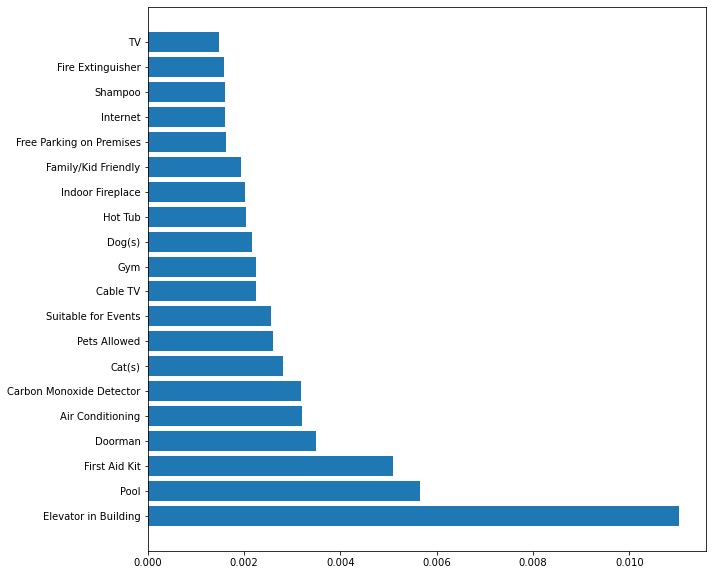

In [1187]:
amenities_importances = importances[importances.index.isin(amenities_list)]

plt.figure(figsize=(10, 10))
plt.barh(amenities_importances.index[:20], amenities_importances['feature_importances'][:20])

Some of this may be surprising, as intuition does not suggest such high importance on the availability of an elevator in a building. However, things like TV or internet are considered standard with almost all properties today. Therefore, additional amenities would make a difference. Amongst the important amenities for price impact are pool availability, pets and hot tub.

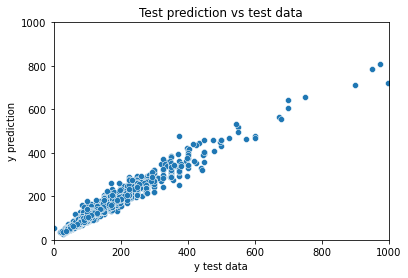

In [1185]:
# Comparing the y predictions to the known y labels
sns.scatterplot(x=y_train, y=y_train_preds2, ci=None)
plt.xlabel('y test data')
plt.ylabel('y prediction')
plt.xlim([0,1000])
plt.ylim([0,1000])
plt.title('Test prediction vs test data');

### Additional visualisations for the blogpost
In this section visualisations are created to be used in a blogpost article.
These visualisation will hopefully help better explain and share the findings from the analysis above to a wider audience.

In [1287]:
# Folium will be used here to create maps that will help show the findings
import folium
from folium import plugins

In [1292]:
# Using the latitude and longitude data provided with the dataset to plot Airbnb properties on the map
locations = listings_sml[['latitude','longitude']]
locations_list = locations.values.tolist()

# Creating a zoomed in map of Seattle
coord = list(listings_sml.iloc[50][['latitude','longitude']])
properties = folium.Map(location=coord, zoom_start=12)

for point in range(0,len(locations_list)):
    folium.CircleMarker(locations_list[point], radius=1).add_to(properties)

The below map shows all the Airbnb properties provided with the *listings.csv* dataset. Properties are scattered all around Seattle, but on it's own this map doesn't provide much insight.

In [1293]:
properties

In [1233]:
locations_list[0]

[47.636289038357184, -122.37102519997765]

In [1241]:
locations = listings_sml[['latitude','longitude','price']]
locations_list = locations.values.tolist()

for point in range(0,50):
    folium.CircleMarker(locations_list[point], radius=1).add_to(seattle_map)

In [1297]:
coord = list(listings_sml.iloc[50][['latitude','longitude']])
seattle_map = folium.Map(location=coord, zoom_start=11)
seattle_map

locations = listings_sml[['latitude','longitude','price']]
locations_list = locations.values.tolist()
plugins.HeatMap(locations_list, radius=11, min_opacity=0.4).add_to(seattle_map)
seattle_map

The below table shows the average list price for the most expensive Airbnb properties by neighbourhood. We can see that Belltown is the most expensive neighbourhoods. This is again visualised on the map above.

In [1285]:
expensive = listings_sml[listings_sml['price']>500][['neighbourhood_cleansed','price']]
expensive.groupby('neighbourhood_cleansed').mean().sort_values(by='price', ascending=False)

,price
neighbourhood_cleansed,
Belltown,824.500000
Westlake,775.000000
West Queen Anne,758.333333
Montlake,750.000000
Southeast Magnolia,750.000000
East Queen Anne,674.500000
Portage Bay,637.500000
Wallingford,627.500000
Eastlake,600.000000
